In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.python.keras.layers import LSTM
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import time
import csv
import pandas_datareader
from pandas_datareader import data
import yfinance as yf
import os

C:\Users\tridi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def read(s):
    df=pd.read_csv(s)
    return df

In [3]:
def s_date(): 
    today_date=datetime.today().date()
    formatted_date = today_date.strftime('%Y-%m-%d')
    return formatted_date

def e_date(g_date):
    d=datetime.strptime(g_date,'%Y-%m-%d')
    ans=d-timedelta(days=365*2)
    formatted_date=ans.strftime('%Y-%m-%d')
    return formatted_date

def download_data():
    df=pd.read_csv('new.csv') #Change
    df
    for i in df.columns:
        x=df[i].tolist()
        folder_name=i
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        for stock_symbol in x:
            stock_data = yf.download(stock_symbol, start="2021-05-19" ,end="2024-05-18") #Change
            filename = f"{stock_symbol}.csv"
            csv_file_path = os.path.join(folder_name,filename)
            stock_data.to_csv(csv_file_path)

In [4]:
def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")
    return formatted_date 

In [5]:
def fillup(df):
    x=df['Date'].iloc[-1]
    start_date=df['Date'][0]
    new_df=pd.DataFrame()
    end_date=x
    date_index = pd.date_range(start=start_date, end=end_date, freq='D')
    new_df['Date']=date_index
    df['Date'] = pd.to_datetime(df['Date'])
    merged_df = pd.merge(df,new_df, on='Date', how='right')
    merged_df=merged_df.interpolate(method='ffill',limit_direction='forward')
    return merged_df

In [6]:
def test(df,index):
    x=df[index].values
    result=adfuller(x)
    if(result[1] >0.05 and result[0]>result[4]['1%'] and result[0]>result[4]['5%'] and result[0]>result[4]['10%']):
        return 0
    else:
        return 1    

In [7]:
def adf(df,index):
    df['Value']=df[index].diff()
    x=df['Value'].mean()
    df['Value']=df['Value'].fillna(x)
    if(test(df,"Value")==0):
        df=adf(df,'Value')
    return df

In [8]:
def minimize(df):
    data=pd.DataFrame()
    data['Date']=df['Date']
    data['Original']=df['Close']
    data['Value']=df['Value']
    return data

In [9]:
def xerox(df):
    df1=pd.DataFrame()
    df1['Date']=df['Date']
    df1['Original']=df['Original']
    df1['Value']=df['Value']
    return df1

In [10]:
def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

In [11]:
def lstm_fun(df1):
    d=df1['Value'].tolist()
    steps=6 
    x,y=split_sequence(d,steps)
    features=1
    x=x.reshape((x.shape[0],x.shape[1],features))
    model_lstm=Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x.shape[1],1)))
    model_lstm.add(LSTM(50, return_sequences=False))
    model_lstm.add(Dense(25))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error',optimizer='adam')
    if(df1.shape[0]<=500):
        e=500
    elif(df1.shape[0]<=2000):
        e=1000
    else:
        e=2000
    model_lstm.fit(x,y,epochs=e,verbose=0)
    return model_lstm

In [12]:
def lstm_run(model_lstm,df1):
    d=df1['Value'].tolist()
    steps=6 
    x,y=split_sequence(d,steps)
    test_data_x= x[-50:]
    test_data_y= y[-50:]

    test_data_pred=model_lstm.predict(test_data_x)
    """ mean = np.mean(test_data_pred)
    abs_deviations = np.abs(test_data_pred-mean)
    mad = np.mean(abs_deviations)
    #print("MAD:", mad)
    mse = mean_squared_error(test_data_y,test_data_pred)
    rmse = np.sqrt(mse)
    #print("RMSE :",rmse)
    def mean_absolute_percentage_error(y_actual, y_predicted):
        return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

    mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
    #print("MAPE:", mape)


    def mean_bias_error(y_actual, y_predicted):
        return mean_squared_error(y_actual,y_predicted)

    mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
    #print("MSE:", mbe)
    print(r2_score(test_data_y,test_data_pred))"""

In [13]:
def starting_date(df1):
    x=df1['Date'].iloc[-1]
    y = x.strftime('%Y-%m-%d')
    return y

In [14]:
def lstm_output(model_lstm,df1):
    d=df1['Value'].tolist()
    steps=6 
    x,y=split_sequence(d,steps)
    test_data_x= x[-50:]
    test_data_y= y[-50:]
    data=df1['Value'].tolist()
    forecasted_df=pd.DataFrame(columns=['Date','Value'])
    start_date=starting_date(df1)
    steps=6
    features=1
    model_lstm=lstm_fun(df1)
    for i in range(360):
        new_date=increase(start_date)
        forecast_input=array(data[-6:])
        x_forecast=forecast_input.reshape(1,steps,features)
        forecasted_y=model_lstm.predict(x_forecast).item()
        forecasted_df.at[i,'Date']=new_date
        forecasted_df.at[i,'Value']=forecasted_y
        data.append(forecasted_y)
        start_date=new_date

    index_old=np.arange(1,51)
    index_new=np.arange(51,411)

    """plt.plot(index_old, test_data_y, color='red')
    plt.plot(index_new,forecasted_df['Value'], color='green')"""
    
    forcasted_dif=forecasted_df['Value']
    dif_list=np.array(forcasted_dif).flatten().tolist()
    last_value=df1.tail(1)['Original'].iloc[0]

    forecasted_og=[]

    for i in range(len(dif_list)):
        n=last_value+dif_list[i]
        forecasted_og.append(n)
        last_value=n

    forecasted_df['Retrive']=forecasted_og

    index_old=np.arange(1,51)
    index_new=np.arange(51,411)

    last_300 = df1['Original'][-50:].tolist()

    """plt.plot(index_old, last_300, color='red')
    plt.plot(index_new,forecasted_df['Retrive'], color='green')"""
    return forecasted_df['Retrive']

In [15]:
def rfr_fun(df2,scaler):
    df2['Value']=scaler.fit_transform(df2[['Value']])
    data=df2['Value'].tolist()
    steps=6 
    n=100
    ans=0
    max_acc=0
    while(n<=2000):
        x,y=split_sequence(data,steps)
        model=RandomForestRegressor(n_estimators=n, random_state = 42)
        model.fit(x,y)
        test_data_x= x[-50:]
        test_data_y= y[-50:]
        test_data_pred=model.predict(test_data_x)
        acc=r2_score(test_data_y,test_data_pred)
        if(acc>max_acc):
            max_acc=acc
            ans=n
        n=n+100
    model=RandomForestRegressor(n_estimators =ans, random_state = 42)
    model.fit(x,y)
    return model

In [16]:
def rfr_run(model,df2):
    d=df2['Value'].tolist()
    steps=6 
    n=100
    ans=0
    max_acc=0
    x,y=split_sequence(d,steps)
    test_data_x= x[-50:]
    test_data_y= y[-50:]

    test_data_pred=model.predict(test_data_x)

    """"mean = np.mean(test_data_pred)
    abs_deviations = np.abs(test_data_pred-mean)
    mad = np.mean(abs_deviations)
    print("MAD:", mad)

    mse = mean_squared_error(test_data_y,test_data_pred)
    rmse = np.sqrt(mse)
    print("RMSE :",rmse)


    def mean_absolute_percentage_error(y_actual, y_predicted):
        return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

    mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
    print("MAPE:", mape)


    def mean_bias_error(y_actual, y_predicted):
        return mean_squared_error(y_actual,y_predicted)

    mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
    print("MSE:", mbe)

    print(r2_score(test_data_y,test_data_pred))"""

In [17]:
def rfr_output(model,df2,scaler):
    data=df2['Value'].tolist()
    forecasted_df=pd.DataFrame(columns=['Date','Value'])
    start_date=starting_date(df2)
    d=df2['Value'].tolist()
    steps=6 
    x,y=split_sequence(d,steps)
    test_data_x= x[-50:]
    test_data_y= y[-50:]
    for i in range(360):
        new_date=increase(start_date)
        forecast_input=array(data[-6:])
        #x_forecast=forecast_input.reshape(1,steps,features) #lstm
        x_forecast=forecast_input.reshape(1,-1)
        forecasted_y=model.predict(x_forecast).item()
        forecasted_df.at[i,'Date']=new_date
        forecasted_df.at[i,'Value']=forecasted_y
        data.append(forecasted_y)
        start_date=new_date

    index_old=np.arange(1,51)
    index_new=np.arange(51,411)

    """lt.plot(index_old, test_data_y, color='red')
    plt.plot(index_new,forecasted_df['Value'], color='green')"""
    forcasted_dif=scaler.inverse_transform(np.array(forecasted_df['Value']).reshape(-1,1))
    dif_list=np.array(forcasted_dif).flatten().tolist()
    last_value=df2.tail(1)['Original'].iloc[0]

    forecasted_og=[]

    for i in range(len(dif_list)):
        n=last_value+dif_list[i]
        forecasted_og.append(n)
        last_value=n

    forecasted_df['Retrive']=forecasted_og

    index_old=np.arange(1,51)
    index_new=np.arange(51,411)

    last_300 = df2['Original'][-50:].tolist()

    """plt.plot(index_old, last_300, color='red')
    plt.plot(index_new,forecasted_df['Retrive'], color='green')"""
    return forecasted_df['Retrive']

In [18]:
def output(retrive_lstm,retrive_rfr):
    result=[]
    for i in range(len(retrive_rfr)):
        result.append(retrive_lstm[i]*0.6 + retrive_rfr[i]*0.4)
    return result

In [19]:
def final_plot(df,op):
    index_old=np.arange(1,51)
    index_new=np.arange(51,411)
    last_300 = df['Original'][-50:].tolist()
    plt.plot(index_old, last_300, color='red')
    plt.plot(index_new,op, color='green')
    plt.show()

In [20]:
# calculate volatility of a stock
"""formula == [annualized volatility= std-dev * sqrt(252)]"""
def historical_annual_volatility(df):
    cp=df['Original']
    daily_returns=cp.pct_change()*100
    volatility=daily_returns.std()
    annualized_volatility=volatility*np.sqrt(252)
    return annualized_volatility

In [21]:
def historical_volatility_plot(df):
    df1=df
    df1['log_rate']=np.log(df1['Original']/df1['Original'].shift(1))
    df1['Volatility']=df1['log_rate'].rolling(window=252).std()*np.sqrt(252)
    #df1[['Original','Volatility']].plot(subplots=True)
    return df1

In [22]:
def apply_fixed_percentage_stop_loss(position_size, entry_price, stop_loss_percentage):
    stop_loss_price = entry_price - (entry_price * stop_loss_percentage / 100)
    maximum_loss = position_size * stop_loss_percentage / 100
    return stop_loss_price, maximum_loss

def historical_volatility_results(df):
    closing_prices=df['Original']
    position_size=252 
    entry_price=closing_prices.iloc[-1]  
    stop_loss_percentage=5   
    stop_loss_price, maximum_loss = apply_fixed_percentage_stop_loss(position_size, entry_price, stop_loss_percentage)
    print(f"Entry Price: {entry_price:.2f}")
    #print(f"Stop-Loss Price: {stop_loss_price:.2f}")
    #print(f"Maximum Loss: {maximum_loss:.2f}")

In [23]:
def high_volatility_measure(df):
    filtered_df = df[df['Volatility'].notnull()]
    average_value = filtered_df['Volatility'].mean()
    return average_value

In [24]:
def long_term_volatility_remove(df,x):
    avg=df['Value'].mean()
    #print(x)
    #print(avg)
    if(x>0.35):
        df.loc[(df['Volatility'].notnull()) & (df['Volatility']>x), 'Value'] = avg
    return df

In [25]:
def make_output_csv(industry):
    folder_name=industry
    filename = f"{industry}_output.csv"
    csv_file_path = os.path.join(folder_name,filename)
    header=["Name","Price","Day","Year","Volatility"]
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(header)

In [26]:
def profit_percentage(industry,s,op,df,vol): # etay oi industrywise change hobe
    price=df['Original'].iloc[-1]
    name=s[:-4]
    folder_name=industry
    filename = f"{industry}_output.csv"
    one_day=((op[0]-price)/price)*100
    one_year=((op[-1]-price)/price)*100
    l=[name,price,one_day,one_year,vol]
    csv_file_path = os.path.join(folder_name,filename)
    with open(csv_file_path, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(l)

In [27]:
def sorting_csv(industry):
    folder_name=industry
    filename = f"{industry}_output.csv"
    csv_file_path = os.path.join(folder_name,filename)
    df=pd.read_csv(csv_file_path)
    day_df=df.sort_values(by='Day',ascending=False,ignore_index=True)
    filename = f"{industry}_output_day.csv"
    csv_file_path = os.path.join(folder_name,filename)
    day_df.to_csv(csv_file_path,index=False)
    year_df=df.sort_values(by='Year',ascending=False,ignore_index=True)
    filename = f"{industry}_output_year.csv"
    csv_file_path = os.path.join(folder_name,filename)
    year_df.to_csv(csv_file_path,index=False)

In [28]:
def auto(industry,str,scaler):
    folder_name=industry
    s=str+".csv"
    csv_file_path = os.path.join(folder_name,s)
    df=read(csv_file_path)
    df=fillup(df)
    df=adf(df,'Close')
    df=minimize(df)
    df1=xerox(df)
    df2=xerox(df)
    vol=historical_annual_volatility(df)
    historical_volatility_results(df)
    df=historical_volatility_plot(df)
    x=high_volatility_measure(df)
    df=long_term_volatility_remove(df,x)
    #plt.plot(df['Value'])
    model_lstm=lstm_fun(df1)
    lstm_run(model_lstm,df1)
    retrive_lstm=lstm_output(model_lstm,df1)
    model_rfr=rfr_fun(df2,scaler)
    rfr_run(model_rfr,df2)
    retrive_rfr=rfr_output(model_rfr,df2,scaler)
    op=output(retrive_lstm,retrive_rfr)
    print(f"After 1 day Price: {op[0]:.2f}")
    print(f"After 1 year Price: {op[-1]:.2f}")
    profit_percentage(industry,s,op,df,vol)
    final_plot(df,op)

In [29]:
def auto_work(industry,str,scaler):
    scaler = MinMaxScaler()
    auto(industry,str,scaler)

In [30]:
def main_1():
    download_data()
    s='new.csv' #change
    df=read(s)
    for i in df.columns:
            x=df[i].tolist()
            make_output_csv(i)
            folder_name=i
            for stock_symbol in x:
                scaler = MinMaxScaler()
                auto_work(i,stock_symbol,scaler)
            sorting_csv(i)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Entry Price: 880.50
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step
After 1 day Price: 878.72
After 1 year Price: 988.81


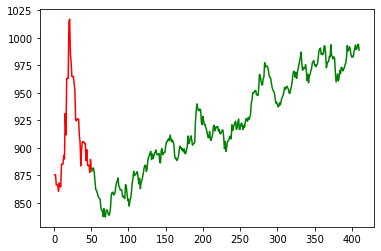

Entry Price: 58.05
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
After 1 day Price: 58.47
After 1 year Price: 44.96


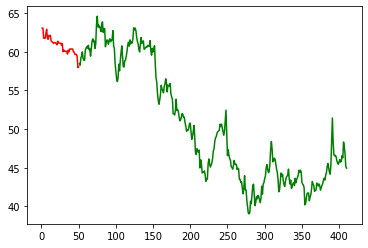

Entry Price: 160.10
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 31ms/step
After 1 day Price: 160.42
After 1 year Price: 283.31


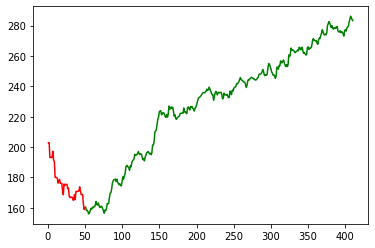

Entry Price: 389.65
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
After 1 day Price: 389.42
After 1 year Price: 2076.53


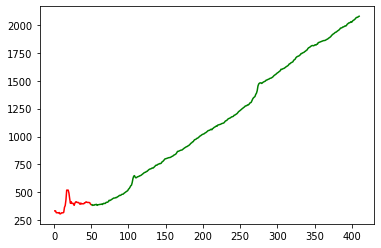

Entry Price: 76.25
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step
After 1 day Price: 79.70
After 1 year Price: 81.12


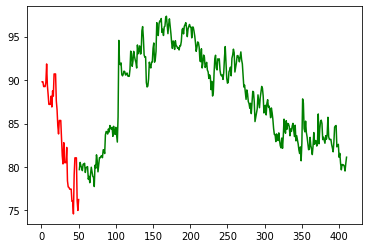

In [31]:
#if __name__ == '__main__': 
main_1()